In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import numpy as np
import hashlib

import cv2
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

import networkx as nx

from minimal.imaging import blit_rooms, draw_sep_nask_wireframe, draw_plan
from minimal.layout import InputLayout, NodeType, NODE_COLOR, into_layout
from minimal.gen import _load_segmentation_dict

from minimal.common import conv_mask
from minimal.rooms import calc_min_area, RectGraph, scale_room_masks
from minimal.walls import create_sep_mask, scale_sep_mask, extract_face_walls
from minimal.join_solving import select_rooms_to_join
from minimal.doors import create_doors, create_front_doors, create_cut_wall_mask

from minimal import sample_graphs

%matplotlib inline

In [4]:
from datasketch import MinHash, MinHashLSH

In [12]:
premade_graphs = [
    sample_graphs.one(),
    sample_graphs.two(),
]

In [49]:
def minhash_for_graph(graph, num_perm=128) -> MinHash:
    m = MinHash(num_perm=num_perm)

    # Encode node types
    for i, t in enumerate(graph.node_types):
        m.update(f"node-{i}-{t}".encode())

    # Canonicalize and sort edges
    canonical_edges = sorted((min(u, v), max(u, v)) for u, v in graph.edges)

    # Encode edges as unordered
    for u, v in canonical_edges:
        m.update(f"edge-{u}-{v}".encode())

    return m

In [34]:
def graph_similarity(g1, g2) -> float:
    # Node type similarity (normalized positional match)
    types1, types2 = g1.node_types, g2.node_types
    match_len = min(len(types1), len(types2))
    type_score = sum(t1 == t2 for t1, t2 in zip(types1, types2)) / max(len(types1), len(types2))

    # Edge similarity (unordered set Jaccard)
    e1 = {frozenset([u, v]) for u, v in g1.edges}
    e2 = {frozenset([u, v]) for u, v in g2.edges}
    edge_score = len(e1 & e2) / len(e1 | e2) if e1 or e2 else 1.0

    return 0.75 * type_score + 0.25 * edge_score

In [23]:
def canonical_graph_signature(graph) -> str:
    # Node types (already sorted in definition)
    node_part = ','.join(map(str, graph.node_types))

    # Edges as unordered sets, then sorted
    edge_part = ','.join(
        f"{min(u,v)}-{max(u,v)}" for u, v in sorted(map(lambda e: (min(e), max(e)), graph.edges))
    )

    return f"nodes:{node_part}|edges:{edge_part}"

In [50]:
signature_to_graph = {}

for graph in premade_graphs:
    sig = canonical_graph_signature(graph)
    signature_to_graph[sig] = graph

# ----

num_perm = 128
lsh = MinHashLSH(threshold=0.8, num_perm=num_perm)

graph_index = []  # Keep for lookup

for idx, graph in enumerate(premade_graphs):
    mh = minhash_for_graph(graph, num_perm)
    lsh.insert(f"graph_{idx}", mh)
    graph_index.append(graph)


def find_closest_graph(query):
    sig = canonical_graph_signature(query)
    if sig in signature_to_graph:
        return signature_to_graph[sig]  # 🎯 Exact match

    query_mh = minhash_for_graph(query, num_perm)
    candidates = lsh.query(query_mh)

    if not candidates:
        return None  # No match found

    # Rerank candidates using full similarity
    best_graph = max(
        (graph_index[int(cid.split('_')[1])] for cid in candidates),
        key=lambda g: graph_similarity(query, g)
    )
    return best_graph

In [36]:
# find_closest_graph(sample_graphs.two()).draw()
sample_graphs.one()

InputLayout(node_types=[0, 1, 2, 2, 3, 4, 14], edges=[(0, 2), (0, 3), (0, 1), (0, 5), (0, 4), (0, 6)], node_labels=[0, 3, 1, 2, 5, 4, 6])

In [53]:
g1 = InputLayout(
    node_types=[0, 1, 2, 14],
    edges=[(0, 2), (0, 3), (0, 1)],
    node_labels=[0, 3, 1, 2])

In [51]:
g2 = InputLayout(
    node_types=[0, 1, 2, 2, 2, 3, 3, 3, 3, 14],
    edges=[(8, 4), (2, 5),  (0, 2), (0, 3),
           (0, 4), (4, 7), (0, 1), (0, 9), (3, 6)],
    node_labels=[0, 1, 3, 5, 7, 4, 6, 8, 2, 9])

In [58]:
# find_closest_graph(g2).draw()

In [67]:
def graph_folder_name(graph) -> str:
    sig = canonical_graph_signature(graph)
    full_hash = hashlib.sha256(sig.encode()).hexdigest()
    return full_hash[:20]

for g in premade_graphs:
    print(graph_folder_name(g))

8cce7eea2efecca9dddd
04210fb7ed75e94f70cd


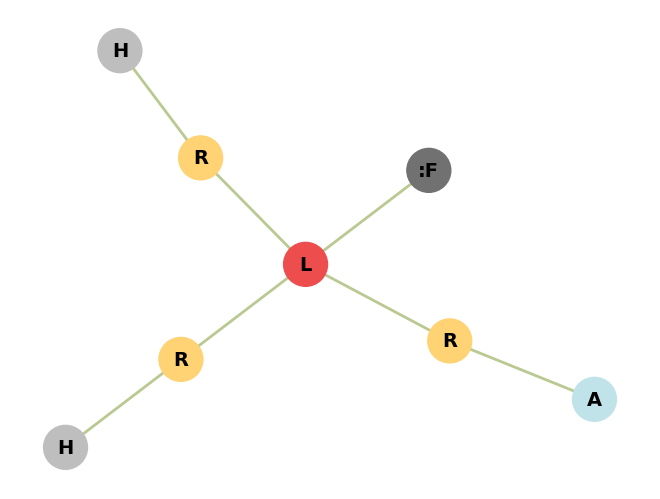

In [75]:
into_layout([14, 0, 2, 2, 3, 4, 3, 2], [(0, 1), (1, 3), (1, 2), (2, 5), (1, 7), (6, 3), (4, 7)]).draw()